# ДЗ 1:


!!!  Все считаем на 1000 итерациях


### Дизайн теста бутстреп
1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (2 балла)

3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)

4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (3 балла)


### Дизайн продолжение

1. Посчитать аналогичный дизайн для:
  - бутстреп + логарифмированная метрика длительности просмотров (4 балла)
  - манна-уитни + метрика длительности просмотров (4 балла)
  - манна-уитни + логарифмированная метрика длительности просмотров (4 балла)
  - t-test + метрика длительности просмотров (4 балла)
  - t-test + логарифмированная метрика длительности просмотров (4 балла)
2. Подробно описать выводы для каждой пары, какие варианты точно не подходят и почему. Объяснить зачем мы логарифмируем метрику и что нам это дает. Аргументированно выбрать 1 пару (метрика + критерий) которым вы будете оценивать АБ тест и какой эффект мы сможем отловить в нашем тесте. (5 баллов)


### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (2 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (1 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (2 балла)

5) Посчитайте результат такого теста и сделайте выводы (10 баллов)





In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
import hashlib
import collections
import requests
import zipfile
import os
import pickle
import warnings


from tqdm import tqdm
from sklearn.utils import shuffle
from base64 import b64encode
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest
from scipy.stats import mannwhitneyu, ttest_ind
from joblib import Memory, Parallel, delayed

memory = Memory('./cache', verbose=0)
plt.style.use('ggplot')
warnings.simplefilter("ignore")
%matplotlib inline

In [3]:
def salt_generator(salt=None):
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')

def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [4]:
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:  57%|█████▋    | 45.1M/78.8M [00:00<00:00, 249MiB/s] 

In [5]:
with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
interactions = pd.read_csv('data_kion/interactions_df.csv')

In [7]:
interactions.head(5)

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


### Дизайн теста бутстреп
1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (2 балла)

3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)

4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (3 балла)


In [8]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

kion dataset download: 100%|██████████| 78.8M/78.8M [00:20<00:00, 249MiB/s]

2021-03-13 2021-08-22


In [9]:
# выделим данные за последние 2 недели (2021-08-09 по 2021-08-22)
data_2_weeks = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=13)]
data_2_weeks = data_2_weeks.groupby('user_id', as_index=False).agg({'total_dur': sum})

In [10]:
# выделим данные за последнюю 1 неделю
data_1_week = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]
data_1_week = data_1_week.groupby('user_id', as_index=False).agg({'total_dur': sum})
data_1_week = data_1_week[(data_1_week['total_dur'] < data_1_week['total_dur'].std() * 3)]

In [11]:
data_2_weeks

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625
...,...,...
266076,999978,11172
266077,999987,27888
266078,999989,4563
266079,999990,997


<Axes: >

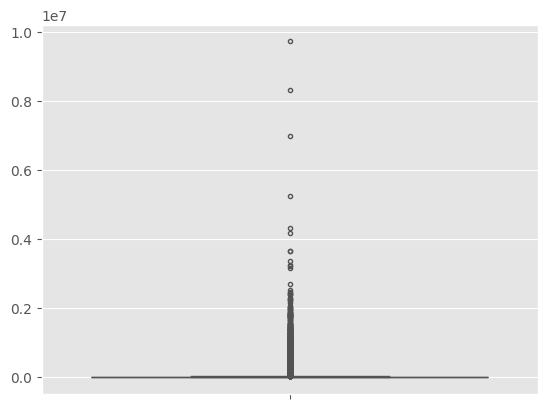

In [ ]:
sns.boxplot(data_2_weeks['total_dur'].values, fliersize=3)

In [12]:
print(data_2_weeks.shape)
data_2_weeks = data_2_weeks[(data_2_weeks['total_dur'] < data_2_weeks['total_dur'].std() * 3)]
print(data_2_weeks.shape)

(266081, 2)
(262794, 2)


<Axes: >

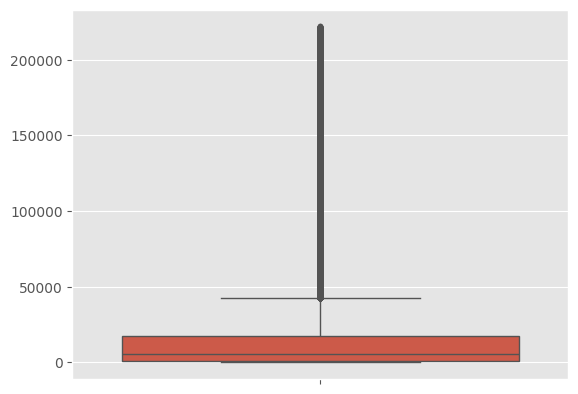

In [ ]:
sns.boxplot(data_2_weeks['total_dur'].values, fliersize=3)

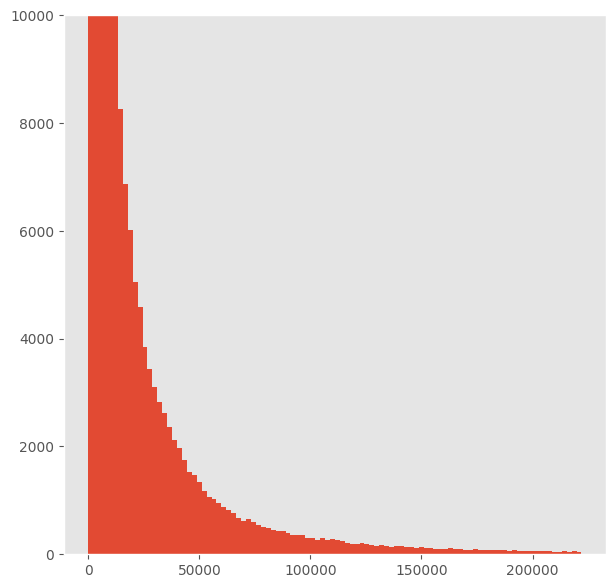

In [ ]:
data_2_weeks['total_dur'].hist(bins=100, figsize=(7,7))
plt.ylim([0, 10000])
plt.grid(False)

In [13]:
def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))

def calc_bootstrap_mean(arr, size=1000):
    samples = np.random.choice(arr, replace=True, size=(size, len(arr)))
    return np.mean(samples, axis=1)

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [14]:
def check_pvalues(pvalues):
    plt.hist(pvalues, bins=10, color='purple');
    stat, p_value = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

    if p_value < 0.05:
        print(f'p_value = {p_value} - p_values неравномерное распределение')
    else:
        print(f'p_value = {p_value} - p_values равномерное распределение')

In [15]:
def bootstrap_iter_sign(data):
    new_df = groups_splitter(data.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    value = sample_a_mean - sample_b_mean
    correctness = (not left_side <= 0 <= right_side)

    return value, correctness

@memory.cache
def bootstrap_significance(data, n_iter, n_jobs):
    result = Parallel(n_jobs = n_jobs)(delayed(bootstrap_iter_sign)(data) for i in tqdm(range(n_iter)))
    values, correctness = zip(*result)
    test_correctness = collections.Counter(list(correctness))

    significance = test_correctness[1]/(test_correctness[1] + test_correctness[0])*100
    print(f'significance: {significance}%')
    return significance, values

#### Сравнение даных за 1 неделю и 2 недели

In [ ]:
significance_1, values_1 = bootstrap_significance(data_1_week, 1000, -1)

significance: 5.4%
p_value = 0.16848479713738784 - p_values равномерное распределение


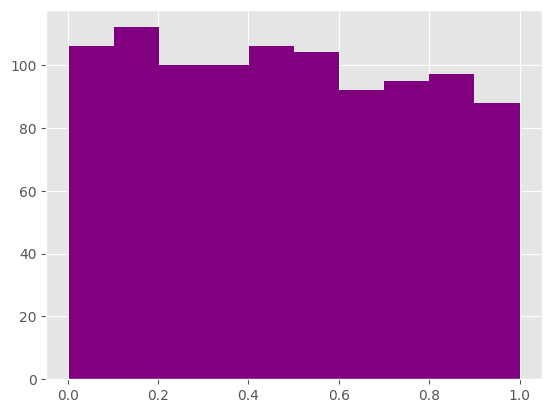

In [ ]:
print(f'significance: {significance_1}%')
p_values_1 = [get_p_value(x) for x in values_1]
check_pvalues(p_values_1)

In [ ]:
significance_2, values_2 = bootstrap_significance(data_2_weeks, 1000, -1)

significance: 4.9%
p_value = 0.6566398438826627 - p_values равномерное распределение


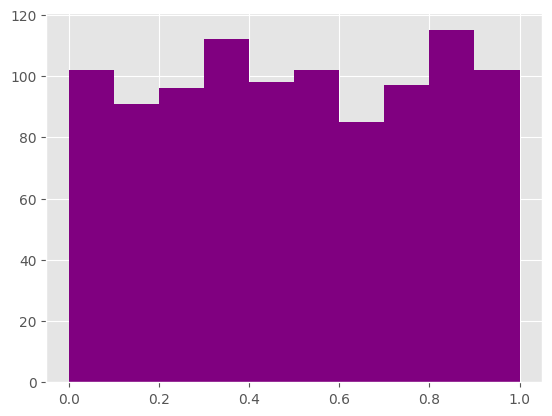

In [ ]:
print(f'significance: {significance_2}%')
p_values_2 = [get_p_value(x) for x in values_2]
check_pvalues(p_values_2)

Корректности за 1 и 2 неделю практически совпадают и близки к 5% (Уровень значимости alpha)

Более низкая корректность для 2-недельного периода указывает на то, что мы с большей уверенностью можем отвергнуть нулевую гипотезу об отсутствии различий между группами


#### Расчет мощности

In [16]:
def bootstrap_iter_power(data, effect):
    new_df = groups_splitter(data.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * (1+effect)

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    powers = (not left_side <= 0 <= right_side)

    return powers

@memory.cache
def bootstrap_power(data, n_iter, effect, n_jobs):
    powers = Parallel(n_jobs = n_jobs)(delayed(bootstrap_iter_power)(data, effect) for i in tqdm(range(n_iter)))
    test_powers = collections.Counter(list(powers))

    power = test_powers[1]/(test_powers[1] + test_powers[0])*100
    print(f'power: {power}%, effect: {effect*100}%')
    return power

In [ ]:
power01 = bootstrap_power(data_2_weeks, 1000, 0.01, -1)

In [ ]:
power03 = bootstrap_power(data_2_weeks, 1000, 0.03, -1)

In [ ]:
power05 = bootstrap_power(data_2_weeks, 1000, 0.05, -1)

In [ ]:
for power, effect in zip([power01, power03, power05], [0.01, 0.03, 0.05]):
    print(f'power: {power}%, effect: {effect*100}%')

power: 31.2%, effect: 1.0%
power: 99.2%, effect: 3.0%
power: 100.0%, effect: 5.0%


1. При эффекте 1% мощность теста составляет всего 31.2%. Такой небольшой эффект мы не сможем обнаружить с помощью нашего теста с большой вероятностью. Такая мощность недостаточна для надежного проведения A/B-теста, так как высок риск пропустить реальный эффект.

2. При эффекте 3% мощность теста значительно возрастает до 99.2%. Это очень хороший показатель, означающий, что тест почти наверняка обнаружит эффект такой величины, если он существует. Выборка обладает большой чувствительностью для выявления эффектов такого размера.

3. При эффекте 5% мощность достигает 100%, что означает практически гарантированное обнаружение эффекта.

Таким образом, наш тест хорошо подходит для обнаружения эффектов от 3% и выше, но недостаточно мощный для обнаружения небольших эффектов порядка 1%. Если нам требуется обнаружения эффектов меньше 3%, необходимо увеличить размер выборки или использовать другие методы анализа.


## MDE

In [17]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)

    return mde*100/metric_mean

In [ ]:
for alpha, beta in zip([0.05]*3, [0.1, 0.2, 0.3]):
    print(f'MDE (α: {alpha} β: {beta}): {get_mde(data_2_weeks["total_dur"], alpha, beta)}')

MDE (α: 0.05 β: 0.1): 1.1112886904889456
MDE (α: 0.05 β: 0.2): 0.9604673863892587
MDE (α: 0.05 β: 0.3): 0.8517146150269004


При уменьшении мощности минимальный обнаруживаемый эффект уменьшается. Мы можем надежно обнаруживать эффекты от ~1% и выше. Для проведения A/B-теста оптимальным выбором будет использование параметров α = 0.05 и β = 0.2, что дает нам возможность обнаруживать эффекты от ~1% с вероятностью > 80%.


### Дизайн продолжение

1. Посчитать аналогичный дизайн для:
  - бутстреп + логарифмированная метрика длительности просмотров (4 балла)
  - манна-уитни + метрика длительности просмотров (4 балла)
  - манна-уитни + логарифмированная метрика длительности просмотров (4 балла)
  - t-test + метрика длительности просмотров (4 балла)
  - t-test + логарифмированная метрика длительности просмотров (4 балла)
2. Подробно описать выводы для каждой пары, какие варианты точно не подходят и почему. Объяснить зачем мы логарифмируем метрику и что нам это дает. Аргументированно выбрать 1 пару (метрика + критерий) которым вы будете оценивать АБ тест и какой эффект мы сможем отловить в нашем тесте. (5 баллов)

### Бутстрэп с логарифмированной метрикой

- зачем логарифмировать метрику:

1. Некоторые метрики могут иметь сильно скошенное распределение с длинным "хвостом". Логарифмирование приводит их распределение ближе к нормальному, что делает статистические тесты более надежными и позволяет использовать статистические методы, которые предполагают нормальность данных (например, t-тест).

2. Снижает влияние выбросов на результаты теста, делая распределение более симметричным и устойчивым к экстремальным значениям.

Учитывая, что наша метрика длительности просмотров имеет сильно скошенное распределение, логарифмирование является эффективным способом нормализации данных и повышения надежности результатов теста. Предполагаю, что логарифмирование приведет к более точным и надежным результатам.

In [35]:
data_2_weeks_log = data_2_weeks.copy()
data_2_weeks_log['total_dur_log'] = np.log2(data_2_weeks_log['total_dur'])

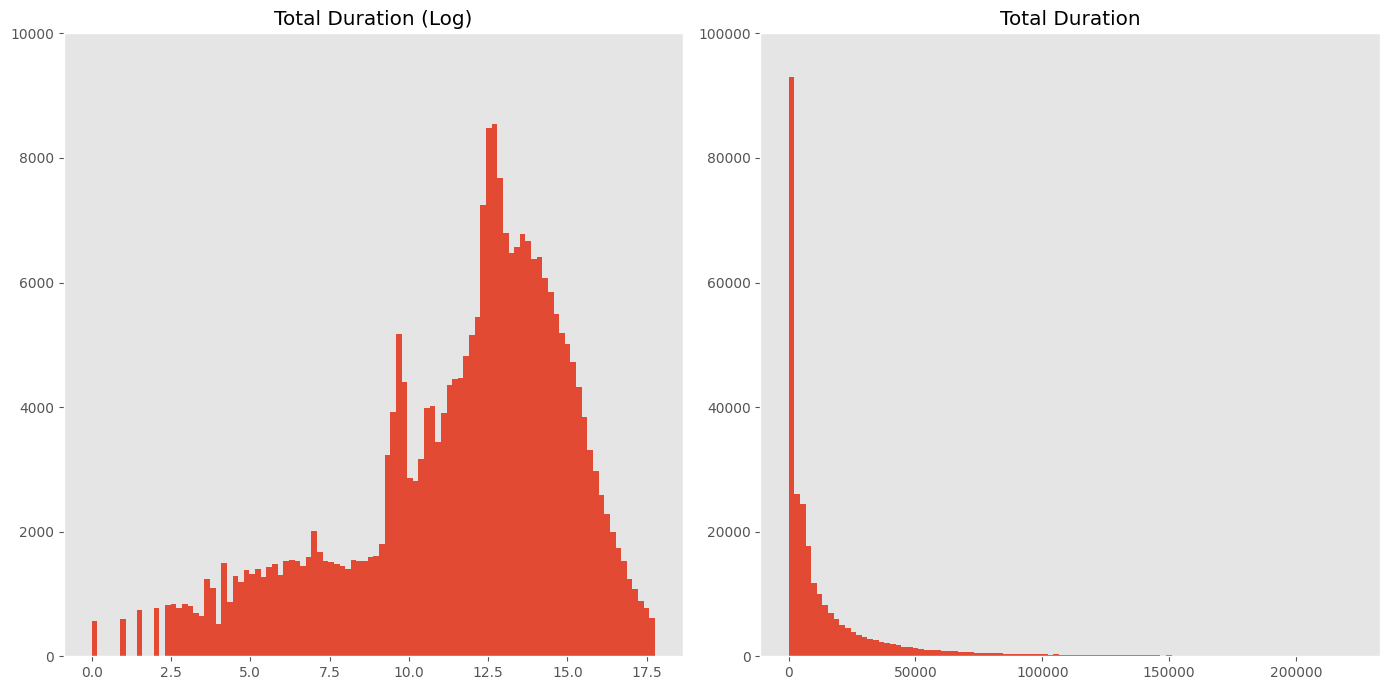

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Один ряд, два столбца

data_2_weeks_log['total_dur_log'].hist(bins=100, ax=axes[0])
axes[0].set_ylim([0, 10000])
axes[0].grid(False)
axes[0].set_title("Total Duration (Log)")

data_2_weeks_log['total_dur'].hist(bins=100, ax=axes[1])
axes[1].set_ylim([0, 100000])
axes[1].grid(False)
axes[1].set_title("Total Duration")

plt.tight_layout()
plt.show()

In [37]:
data_2_weeks_log.drop(columns=['total_dur'], inplace=True)
data_2_weeks_log.rename(columns={'total_dur_log': 'total_dur'}, inplace=True)

In [ ]:
significance_2_log, values_2_log = bootstrap_significance(data_2_weeks_log, 1000, -1)

significance: 5.2%
p_value = 0.40574787986631133 - p_values равномерное распределение


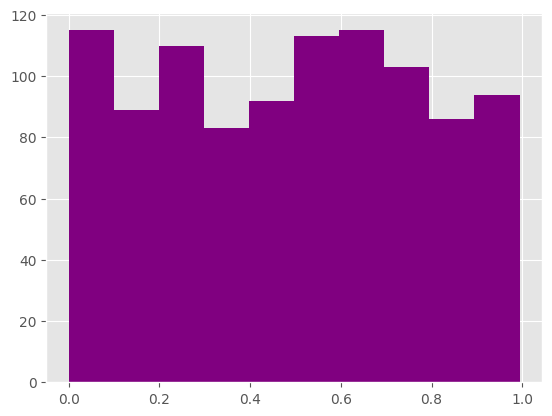

In [ ]:
print(f'significance: {significance_2_log}%')
p_values_2_log = [get_p_value(x) for x in values_2_log]
check_pvalues(p_values_2_log)

Корректность на логарифмированной метрике ухудшилась (с 4.9% до5.2%) -> логарифмирование не привело к улучшению результатов теста. Проверим это на других тестах.

## Другие тесты

In [60]:
def check_significance(pvalues):
    p_values = np.array(pvalues)
    significance = p_values[p_values < 0.05].shape[0] / p_values.shape[0] * 100
    print(f'significance: {significance}%')

def design_iter(data, test, test_type):
    week1_hash = groups_splitter(data, columns=['user_id', 'total_dur', 'group'])

    res = test(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values
    )
    if test_type == "ttest_ind":
        return res.pvalue
    elif test_type == "mannwhitneyu":
        return res

@memory.cache
def run_design(data, test_type, n_iter, n_jobs = -1):
    pvalues = []

    tests = {"mannwhitneyu": mannwhitneyu, "ttest_ind": ttest_ind}
    if test_type not in tests:
        raise Exception("Теста нет в списке")
    test = tests[test_type]
    pvalues = Parallel(n_jobs = n_jobs)(delayed(design_iter)(data, test, test_type) for i in tqdm(range(n_iter)))

    return pvalues

### манна-уитни + метрика длительности просмотров

In [30]:
pvalues_mw = run_design(data_2_weeks, "mannwhitneyu", 1000)


100%|██████████| 1000/1000 [03:35<00:00,  4.64it/s]


significance: 4.7%
p_value = 0.6373420168799464 - p_values равномерное распределение


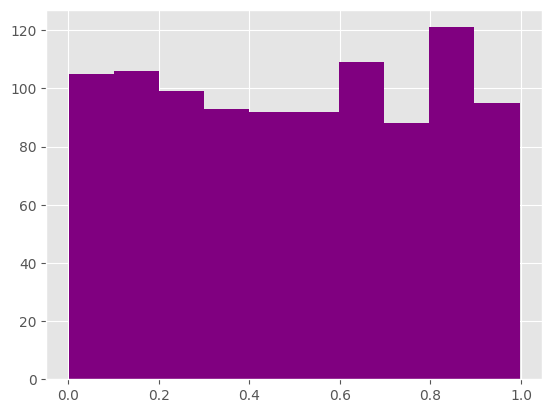

In [31]:
check_significance(pvalues_mw)
check_pvalues(pvalues_mw)

### манна-уитни + логарифмированная метрика длительности просмотров

In [38]:
pvalues_mw_log = run_design(data_2_weeks_log, "mannwhitneyu", 1000)


100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]


significance: 4.9%
p_value = 0.6900371507918334 - p_values равномерное распределение


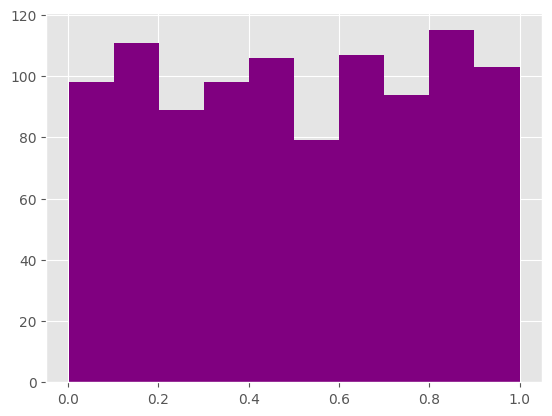

In [39]:
check_significance(pvalues_mw_log)
check_pvalues(pvalues_mw_log)

### t-test + метрика длительности просмотров

In [61]:
pvalues_tt = run_design(data_2_weeks, "ttest_ind", 1000)


100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]


significance: 4.7%
p_value = 0.4965472252356269 - p_values равномерное распределение


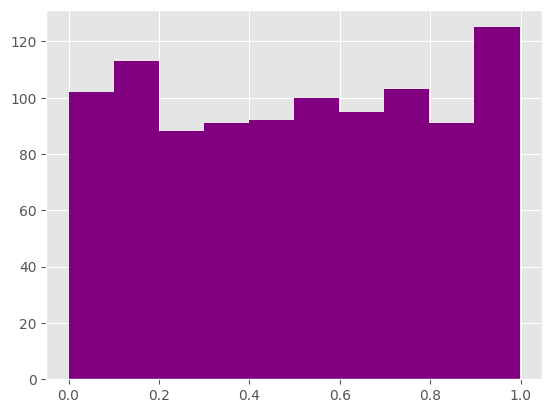

In [62]:
check_significance(pvalues_tt)
check_pvalues(pvalues_tt)

### t-test + логарифмированная метрика длительности просмотров

In [63]:
pvalues_tt_log = run_design(data_2_weeks_log, "ttest_ind", 1000)


100%|██████████| 1000/1000 [03:22<00:00,  4.94it/s]


significance: 4.8%
p_value = 0.8620786652180069 - p_values равномерное распределение


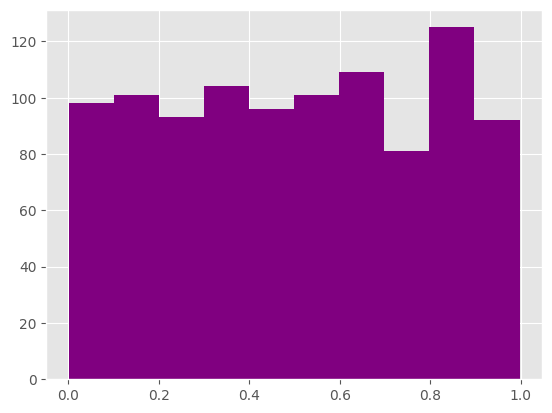

In [64]:
check_significance(pvalues_tt_log)
check_pvalues(pvalues_tt_log)

#### Результаты

Другие тесты показали, что логарифмирование не привело к улучшению результатов теста.
Наилучшую корректность показали:
 - t-тест на оригинальной метрике
 - манна-уитни на оригинальной метрике
 







### Мощность + MDE для лучших пар

In [68]:
def check_power(pvalues):
    p_values = np.array(pvalues)
    power = p_values[p_values < 0.05].shape[0] / p_values.shape[0] * 100
    print(f'power: {power}%')

def design_iter_power(data, test, test_type, effect):
    week1_hash = groups_splitter(data, columns=['user_id', 'total_dur', 'group'])

    res = test(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values * (1+effect)
    )
    if test_type == "ttest_ind":
        return res.pvalue
    elif test_type == "mannwhitneyu":
        return res

@memory.cache
def run_design_power(data, test_type, n_iter, effect, n_jobs = -1):
    pvalues = []

    tests = {"mannwhitneyu": mannwhitneyu, "ttest_ind": ttest_ind}
    if test_type not in tests:
        raise Exception("Теста нет в списке")
    test = tests[test_type]
    pvalues = Parallel(n_jobs = n_jobs)(delayed(design_iter_power)(data,
                                                                   test,
                                                                   test_type,
                                                                   effect)
    for i in range(n_iter))

    return pvalues

In [71]:
### манна-уитни + метрика длительности просмотров
### t-test + метрика длительности просмотров

for test in ["mannwhitneyu", "ttest_ind"]:
    for effect in [0.01, 0.02, 0.03]:
        values = run_design_power(data_2_weeks, test, 1000, effect)
        print(f"test: {test}, effect: {effect}")
        check_power(values)
        print(f"##############################")

  0%|          | 0/1000 [05:15<?, ?it/s]


test: mannwhitneyu, effect: 0.01
power: 23.0%
##############################
test: mannwhitneyu, effect: 0.02
power: 71.8%
##############################
test: mannwhitneyu, effect: 0.03
power: 95.6%
##############################
test: ttest_ind, effect: 0.01
power: 30.599999999999998%
##############################
test: ttest_ind, effect: 0.02
power: 80.5%
##############################
test: ttest_ind, effect: 0.03
power: 98.8%
##############################




1. **Тест Манна-Уитни**:
   - При эффекте 1% мощность составляет всего 23% - недостаточно для надежного обнаружения эффекта
   - При эффекте 2% мощность достигает 71.8% -  приемлемый уровень
   - При эффекте 3% мощность составляет 95.6% - отличный показатель

2. **t-тест**:
   - При эффекте 1% мощность составляет 30.6% - чем у теста Манна-Уитни, но все еще недостаточно
   - При эффекте 2% мощность достигает 80.5% -  превышает стандартный порог в 80%
   - При эффекте 3% мощность составляет 98.8% - отличный показатель

Вывод: t-тест демонстрирует более высокую мощность для всех уровней эффекта. Для надежного обнаружения эффекта предпочтительнее использовать t-тест.


#### MDE для лучшей пары (t-тест + метрика длительности просмотров)

In [98]:
alpha = 4.7/100
beta = 1 - 98.8/100
print(f'MDE (α: {alpha} β: {beta}): {get_mde(data_2_weeks["total_dur"], alpha, beta)}')

MDE (α: 0.047 β: 0.01200000000000001): 1.4547748058808987


- Минимальный обнаруживаемый эффект (MDE) для t-теста с метрикой длительности просмотров составляет 1.45% при уровне значимости α = 0.047 и мощности 1-β = 0.988 (или β = 0.012). 



## A/B test

In [95]:
def a_b_test(data, test_type):
    tests = {"mannwhitneyu": mannwhitneyu, "ttest_ind": ttest_ind}
    if test_type not in tests:
        raise Exception("Теста нет в списке")
    ab_data = data_2_weeks.copy()
    ab_data['total_dur'] = ab_data['total_dur'].where(ab_data['total_dur'] >= 500, 0)
    ab_data = groups_splitter(ab_data.copy(), columns=['user_id', 'total_dur', 'group'],
                              user_salt='kiontestmodel20210805')

    ab_data['total_dur'] = ab_data['total_dur'].astype(float)
    top_10_percent = ab_data[ab_data['group'] == "B"]['total_dur'].quantile(0.9)
    ab_data.loc[((ab_data['group'] == "B") &
                (ab_data['total_dur'] >= top_10_percent)),
                'total_dur'] *= 1.025
    res = tests[test_type](
        ab_data[ab_data['group'] == 'A']['total_dur'].values,
        ab_data[ab_data['group'] == 'B']['total_dur'].values
    )

    mean_A = ab_data[ab_data['group'] == 'A']['total_dur'].mean()
    mean_B = ab_data[ab_data['group'] == 'B']['total_dur'].mean()
    effect_data = (mean_B - mean_A) / mean_A * 100
    print(f"pvalue: {res.pvalue}")
    print(f"mean A: {mean_A}")
    print(f"mean B: {mean_B}")
    print(f"effect: {effect_data}%")

In [97]:
a_b_test(data_2_weeks, "ttest_ind")

pvalue: 0.03349652724165618
mean A: 15808.000629116736
mean B: 16041.820277312914
effect: 1.4791222095823207%


In [96]:
# дополнительно проверим манна-уитни
a_b_test(data_2_weeks, "mannwhitneyu")

pvalue: 0.09187290419766353
mean A: 15808.000629116736
mean B: 16041.820277312914
effect: 1.4791222095823207%


## Выводы по A/B тесту

#### Дизайн теста
- Проведен A/A тест для проверки корректности процедуры.
- Выбрана метрика без логарифмирования, так как оно не помогло улучшить результаты теста.
- Для A/B теста использован t-test.

#### Результаты A/B теста (t-test)
- **p-value**: 0.0335
- **Среднее значение группы A**: 15,808.00
- **Среднее значение группы B**: 16,041.82
- **Эффект**: +1.48%

#### Дополнительная проверка (U-тест Манна-Уитни)
- **p-value**: 0.0919
- **Средние значения** аналогичны t-тесту.
- Эффект такой же: +1.48%.

#### Интерпретация
- t-test показывает статистически значимое различие (p < 0.05), с эффектом (+1.48%).
- Манна-Уитни тест не подтверждает значимость результата (p > 0.05).
- Различие между группами определенно присутствует, что подтверждается t-тестом, а расхождение в тестах дает возможность для дальнейшего исследования.

#### Рекомендации
- Провести дополнительный анализ распределения данных.
- Провести дополннительные эксперименты с другими метриками и тестами.
